In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.parquet as pq

In [0]:
import requests

In [0]:
# download dataset from google drive
def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

In [0]:
url_sg = "https://drive.google.com/open?id=1NVglfRzNxXI5VZ-HSxqAQWIxicrUFa1i"
file_id = '1NVglfRzNxXI5VZ-HSxqAQWIxicrUFa1i'
destinationSG = '/content/grab-posis-city=Singapore.zip'

In [0]:
download_file_from_google_drive(file_id, destinationSG)

In [0]:
import zipfile
directorySG = destinationSG

In [0]:
zip_ref = zipfile.ZipFile(directorySG, 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

#Load Dataset

In [0]:
dataset_SG = pq.ParquetDataset('/tmp/city=Singapore')
dataset_SG = dataset_SG.read()
dataset_SG = dataset_SG.to_pandas()

# SG dataset preprocess

In [0]:
dataset_SG['pingtimestamp'] = pd.to_datetime(dataset_SG['pingtimestamp'], unit='s')
SG_car = dataset_SG.drop(columns=['driving_mode'])
del dataset_SG

In [0]:
SG_car['trj_id'] = SG_car['trj_id'].astype('int')

In [0]:
SG_car = SG_car.sort_values(by=['trj_id', 'pingtimestamp'])

In [0]:
# get the travel time by substracting difference in first pingtimestamp with the last pingtimestamp for each trajectory ID
SG_car['travel_time'] = SG_car.groupby(['trj_id']).pingtimestamp.transform(lambda x: x.max() - x.min()).astype('timedelta64[s]')
SG_car['pickup_time'] = SG_car.groupby(['trj_id']).pingtimestamp.transform(lambda x: x.min())
SG_car['dropoff_time'] = SG_car.groupby(['trj_id']).pingtimestamp.transform(lambda x: x.max())

In [14]:
# collect garbage, run when RAM is almost full or just need to clear up RAM
import gc
gc.collect()

0

In [0]:
def extractCoordinateAndUpdateDF(df, variable_name, timestamp_col, coordinate_component):
  """ Create new column containing a coordinate component of geolocation at a certain timestamp"""
  coord_series = df.groupby(['trj_id']).apply(lambda x: x[x['pingtimestamp'] == x[timestamp_col]][coordinate_component])
  coord_series = coord_series.reset_index().set_index('level_1')
  df_update = df.merge(coord_series, how='left', left_on='trj_id', right_on='trj_id', suffixes=['', '_{}'.format(variable_name)])
  return df_update

In [0]:
# create and merge pickup latitude into SG_car
SG_car = extractCoordinateAndUpdateDF(SG_car, 'pickup', 'pickup_time', 'rawlat')
# create and merge pickup longitude into SG_car
SG_car = extractCoordinateAndUpdateDF(SG_car, 'pickup', 'pickup_time', 'rawlng')
# add drop off latitude
SG_car = extractCoordinateAndUpdateDF(SG_car, 'dropoff', 'dropoff_time', 'rawlat')
# add drop off longitude
SG_car = extractCoordinateAndUpdateDF(SG_car, 'dropoff', 'dropoff_time', 'rawlng')

In [0]:
SG_car = SG_car.reset_index()
SG_car = SG_car.drop(labels=['index'], axis=1)

# Preprocess hour and day to cyclical data
we will use sin and cos function to model the time and day into a continuos cyclical cycle.

In [18]:
SG_car_aug_colapse = SG_car.drop_duplicates(subset=['trj_id', 'pickup_time'], keep='first')
# add pickup_hour and pickup_day column
SG_car_aug_colapse['pickup_hour'] = SG_car_aug_colapse['pickup_time'].dt.hour
SG_car_aug_colapse['pickup_day'] = SG_car_aug_colapse['pickup_time'].dt.dayofweek
SG_car_aug_colapse['sin_pickup_hour'] = np.sin(2*np.pi*SG_car_aug_colapse.pickup_hour/24)
SG_car_aug_colapse['cos_pickup_hour'] = np.cos(2*np.pi*SG_car_aug_colapse.pickup_hour/24)
SG_car_aug_colapse['sin_pickup_day'] = np.sin(2*np.pi*SG_car_aug_colapse.pickup_day/7)
SG_car_aug_colapse['cos_pickup_day'] = np.cos(2*np.pi*SG_car_aug_colapse.pickup_day/7)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [19]:
SG_car_aug_colapse

,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,travel_time,pickup_time,dropoff_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff,pickup_hour,pickup_day,sin_pickup_hour,cos_pickup_hour,sin_pickup_day,cos_pickup_day
0,2,android,2019-04-09 02:38:48,1.270377,103.857875,25.623161,100,32.000,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354,2,1,5.000000e-01,0.866025,0.781831,0.623490
1134,3,ios,2019-04-12 08:32:16,1.282591,103.851082,0.000000,96,30.000,1158.0,2019-04-12 08:32:16,2019-04-12 08:51:34,1.282591,103.851082,1.332855,103.977278,8,4,8.660254e-01,-0.500000,-0.433884,-0.900969
2067,4,android,2019-04-13 10:42:40,1.355363,103.863157,5.960000,217,3.900,1366.0,2019-04-13 10:42:40,2019-04-13 11:05:26,1.355363,103.863157,1.343218,103.858504,10,5,5.000000e-01,-0.866025,-0.974928,-0.222521
2946,5,ios,2019-04-20 01:39:08,1.340301,103.775742,4.760463,91,6.000,1328.0,2019-04-20 01:39:08,2019-04-20 02:01:16,1.340301,103.775742,1.303071,103.900220,1,5,2.588190e-01,0.965926,-0.974928,-0.222521
4107,8,android,2019-04-11 07:24:34,1.333936,103.953225,15.250000,318,4.288,1210.0,2019-04-11 07:24:34,2019-04-11 07:44:44,1.333936,103.953225,1.309601,103.833983,7,3,9.659258e-01,-0.258819,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30323980,83955,android,2019-04-08 22:27:51,1.396872,103.747718,11.609461,191,3.900,1112.0,2019-04-08 22:27:51,2019-04-08 22:46:23,1.396872,103.747718,1.319548,103.843496,22,0,-5.000000e-01,0.866025,0.000000,1.000000
30325037,83956,ios,2019-04-09 22:09:13,1.396533,103.747537,3.212061,196,6.000,983.0,2019-04-09 22:09:13,2019-04-09 22:25:36,1.396533,103.747537,1.322236,103.841737,22,1,-5.000000e-01,0.866025,0.781831,0.623490
30325931,83957,android,2019-04-21 01:20:41,1.301317,103.899443,11.049027,244,5.600,1382.0,2019-04-21 01:20:41,2019-04-21 01:43:43,1.301317,103.899443,1.410657,103.778843,1,6,2.588190e-01,0.965926,-0.781831,0.623490
30327120,83999,android,2019-04-17 11:22:25,1.298612,103.853801,0.000000,0,4.137,1212.0,2019-04-17 11:22:25,2019-04-17 11:42:37,1.298612,103.853801,1.341311,103.981728,11,2,2.588190e-01,-0.965926,0.974928,-0.222521


# Analysis

In [0]:
from sklearn.cluster import MiniBatchKMeans
coords = np.vstack((SG_car_aug_colapse[['rawlat_pickup', 'rawlng_pickup']].values,
                    SG_car_aug_colapse[['rawlat_dropoff', 'rawlng_dropoff']].values))

sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [21]:
SG_car_aug_colapse.loc[:, 'pickup_cluster'] = kmeans.predict(SG_car_aug_colapse[['rawlat_pickup', 'rawlng_pickup']])
SG_car_aug_colapse.loc[:, 'dropoff_cluster'] = kmeans.predict(SG_car_aug_colapse[['rawlat_dropoff', 'rawlng_dropoff']])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

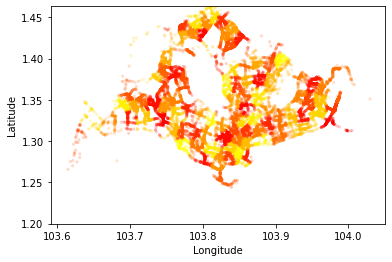

In [22]:
city_long_border = (103.590506, 104.050822)
city_lat_border = (1.199654, 1.463254)

fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(SG_car_aug_colapse.rawlng_pickup.values[:500000], SG_car_aug_colapse.rawlat_pickup.values[:500000], s=10, lw=0,
           c=SG_car_aug_colapse.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()



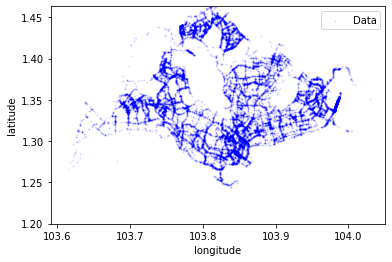

In [23]:
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(SG_car_aug_colapse['rawlng_pickup'].values[:100000], SG_car_aug_colapse['rawlat_pickup'].values[:100000],
              color='blue', s=1, label='Data', alpha=0.1)
ax.legend(loc=0)
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

# Feature Extraction

In [24]:
from sklearn.decomposition import PCA
pca = PCA().fit(coords)

SG_car_aug_colapse['pickup_pca0'] = pca.transform(SG_car_aug_colapse[['rawlat_pickup', 'rawlng_pickup']])[:, 0]
SG_car_aug_colapse['pickup_pca1'] = pca.transform(SG_car_aug_colapse[['rawlat_pickup', 'rawlng_pickup']])[:, 1]
SG_car_aug_colapse['dropoff_pca0'] = pca.transform(SG_car_aug_colapse[['rawlat_dropoff', 'rawlng_dropoff']])[:, 0]
SG_car_aug_colapse['dropoff_pca1'] = pca.transform(SG_car_aug_colapse[['rawlat_dropoff', 'rawlng_dropoff']])[:, 1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [25]:
SG_car_aug_colapse

,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,travel_time,pickup_time,dropoff_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff,pickup_hour,pickup_day,sin_pickup_hour,cos_pickup_hour,sin_pickup_day,cos_pickup_day,pickup_cluster,dropoff_cluster,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,2,android,2019-04-09 02:38:48,1.270377,103.857875,25.623161,100,32.000,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354,2,1,5.000000e-01,0.866025,0.781831,0.623490,87,56,-0.025486,-0.076384,0.041837,0.094437
1134,3,ios,2019-04-12 08:32:16,1.282591,103.851082,0.000000,96,30.000,1158.0,2019-04-12 08:32:16,2019-04-12 08:51:34,1.282591,103.851082,1.332855,103.977278,8,4,8.660254e-01,-0.500000,-0.433884,-0.900969,97,23,-0.017611,-0.064838,-0.138717,-0.003314
2067,4,android,2019-04-13 10:42:40,1.355363,103.863157,5.960000,217,3.900,1366.0,2019-04-13 10:42:40,2019-04-13 11:05:26,1.355363,103.863157,1.343218,103.858504,10,5,5.000000e-01,-0.866025,-0.974928,-0.222521,39,2,-0.023023,0.008731,-0.019494,-0.003787
2946,5,ios,2019-04-20 01:39:08,1.340301,103.775742,4.760463,91,6.000,1328.0,2019-04-20 01:39:08,2019-04-20 02:01:16,1.340301,103.775742,1.303071,103.900220,1,5,2.588190e-01,0.965926,-0.974928,-0.222521,16,43,0.062661,-0.014213,-0.064685,-0.039977
4107,8,android,2019-04-11 07:24:34,1.333936,103.953225,15.250000,318,4.288,1210.0,2019-04-11 07:24:34,2019-04-11 07:44:44,1.333936,103.953225,1.309601,103.833983,7,3,9.659258e-01,-0.258819,0.433884,-0.900969,83,4,-0.114666,-0.004423,0.001871,-0.039493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30323980,83955,android,2019-04-08 22:27:51,1.396872,103.747718,11.609461,191,3.900,1112.0,2019-04-08 22:27:51,2019-04-08 22:46:23,1.396872,103.747718,1.319548,103.843496,22,0,-5.000000e-01,0.866025,0.000000,1.000000,67,30,0.095710,0.039577,-0.006699,-0.028723
30325037,83956,ios,2019-04-09 22:09:13,1.396533,103.747537,3.212061,196,6.000,983.0,2019-04-09 22:09:13,2019-04-09 22:25:36,1.396533,103.747537,1.322236,103.841737,22,1,-5.000000e-01,0.866025,0.781831,0.623490,67,42,0.095859,0.039224,-0.004703,-0.026205
30325931,83957,android,2019-04-21 01:20:41,1.301317,103.899443,11.049027,244,5.600,1382.0,2019-04-21 01:20:41,2019-04-21 01:43:43,1.301317,103.899443,1.410657,103.778843,1,6,2.588190e-01,0.965926,-0.781831,0.623490,43,35,-0.064071,-0.041795,0.065966,0.056133
30327120,83999,android,2019-04-17 11:22:25,1.298612,103.853801,0.000000,0,4.137,1212.0,2019-04-17 11:22:25,2019-04-17 11:42:37,1.298612,103.853801,1.341311,103.981728,11,2,2.588190e-01,-0.965926,0.974928,-0.222521,73,23,-0.018864,-0.048636,-0.142380,0.005511


# Modelling

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

train, test = train_test_split(SG_car_aug_colapse, test_size=0.3, train_size = 0.7)
train, validate = train_test_split(SG_car_aug_colapse, test_size = 0.25, train_size = 0.75)
print(len(train))
print(len(validate))
print(len(test))

21000
7000
8400


In [0]:
X_train = train.drop(['travel_time', 'trj_id', 'osname', 'pingtimestamp', 'rawlat', 'rawlng', 'speed', 'bearing', 'accuracy', 'pickup_time', 'dropoff_time'], axis=1)
Y_train = train["travel_time"]
X_val = validate.drop(['travel_time', 'trj_id', 'osname', 'pingtimestamp', 'rawlat', 'rawlng', 'speed', 'bearing', 'accuracy', 'pickup_time', 'dropoff_time'], axis=1)
Y_val = validate["travel_time"]
X_test = test.drop(['travel_time', 'trj_id', 'osname', 'pingtimestamp', 'rawlat', 'rawlng', 'speed', 'bearing', 'accuracy', 'pickup_time', 'dropoff_time'], axis=1)
Y_test = test["travel_time"]

## Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression

In [81]:
regressor = LinearRegression()  
regressor.fit(X_train, Y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [82]:
#To retrieve the intercept:
print(regressor.intercept_)#For retrieving the slope:
print(regressor.coef_)

12087838415810.11
[-3.57503718e+09  9.80622090e+10  2.01392997e+09 -2.14450870e+11
  1.13788223e+00  2.14243183e+01  1.09339780e+01 -5.72677298e+01
 -4.99518871e+01 -8.47145191e+01  1.01066589e-01 -2.20932007e-01
  9.79813367e+10 -5.35120558e+09 -2.13746546e+11  1.74827290e+10]


In [83]:
y_pred = regressor.predict(X_test)
mse = mean_squared_error(Y_test,y_pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 312.75


## Lasso

In [0]:
from sklearn.linear_model import Lasso

In [0]:
clf = Lasso(alpha=0.1).fit(X_train,Y_train)

In [86]:
pred = clf.predict(X_test)
clf.predict(X_test)

array([1281.09063006, 1388.84711957, 1362.42147402, ..., 1288.71060653,
       1281.10459452, 1380.70914129])

In [87]:
y_pred = regressor.predict(X_test)
mse = mean_squared_error(Y_test,y_pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 312.75


In [0]:
from sklearn.linear_model import LassoLarsCV

In [89]:
reg = LassoLarsCV(cv=20).fit(X_train, Y_train)
reg.score(X_train, Y_train)
reg.alpha_


0.0019186543953214335

In [90]:
pred = reg.predict(X_test)
reg.predict(X_test)

array([1279.75832499, 1393.00855554, 1363.01163922, ..., 1289.83716178,
       1277.36126189, 1376.65900369])

In [91]:
mse = mean_squared_error(Y_test,pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 312.74


## Ridge

In [0]:
from sklearn.linear_model import Ridge

In [93]:
rng = np.random.RandomState(0)
clf = Ridge(alpha=1.0)
clf.fit(X_train, Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
pred = clf.predict(X_test)

In [95]:
mse = mean_squared_error(Y_test,pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 312.75


## MLP

In [0]:
from sklearn.neural_network import MLPRegressor

In [0]:
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, Y_train)

In [98]:
pred = regr.predict(X_test)
regr.predict(X_test)


array([1200.89545264, 1324.37924424, 1365.76960766, ..., 1325.48351323,
       1233.91542344, 1343.94131909])

In [99]:
regr.score(X_test, Y_test)

0.19738681010335857

In [100]:
mse = mean_squared_error(Y_test,pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 299.96


## Decision Tree

In [0]:
from sklearn import tree
clf = tree.DecisionTreeClassifier().fit(X_train, Y_train)

In [102]:
pred = clf.predict(X_test)
clf.predict(X_test)

array([1086., 1308., 1783., ..., 1608., 1584., 1129.])

In [103]:
mse = mean_squared_error(Y_test,pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 203.75


## Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)

In [105]:
pred = clf.predict(X_test)
clf.predict(X_test)

array([1086., 1308.,  985., ..., 1127., 1584.,  872.])

In [106]:
mse = mean_squared_error(Y_test,pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 210.14


## SVM

In [107]:
from sklearn import svm

regr = svm.SVR()
regr.fit(X_train, Y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [108]:
pred = regr.predict(X_test)
regr.predict(X_test)

array([1177.96421907, 1182.96548049, 1195.05754996, ..., 1188.04096863,
       1178.56000375, 1173.9831625 ])

In [109]:
mse = mean_squared_error(Y_test,pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 341.84


## XGBoost

In [0]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_val, label=Y_val)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [111]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 700, watchlist, early_stopping_rounds=40,
      maximize=False, verbose_eval=1)
print('Modeling RMSE %.5f' % model.best_score)

[0]	train-rmse:702.715	valid-rmse:694.298
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 40 rounds.
[1]	train-rmse:436.334	valid-rmse:427.858
[2]	train-rmse:335.505	valid-rmse:327.207
[3]	train-rmse:297.194	valid-rmse:295.527
[4]	train-rmse:281.142	valid-rmse:281.938
[5]	train-rmse:274.508	valid-rmse:278.554
[6]	train-rmse:264.005	valid-rmse:276.573
[7]	train-rmse:260.299	valid-rmse:275.388
[8]	train-rmse:251.993	valid-rmse:273.61
[9]	train-rmse:250.127	valid-rmse:273.128
[10]	train-rmse:248.366	valid-rmse:271.808
[11]	train-rmse:244.805	valid-rmse:270.941
[12]	train-rmse:242.537	valid-rmse:270.798
[13]	train-rmse:241.38	valid-rmse:270.83
[14]	train-rmse:238.677	valid-rmse:270.011
[15]	train-rmse:233.384	valid-rmse:269.683
[16]	train-rmse:230.908	valid-rmse:269.767
[17]	train-rmse:225.92	valid-rmse:269.505
[18]	train-rmse:224.7	valid-rmse:269.133
[19]	train-rmse:223.407	valid-rmse:268.966
[20]	train-

In [0]:
dtest = xgb.DMatrix(X_test)


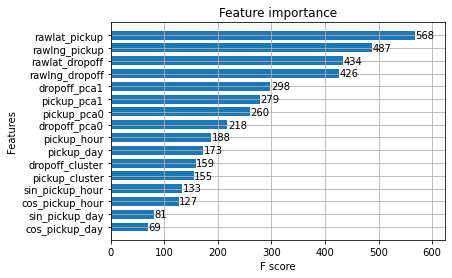

In [113]:
xgb.plot_importance(model, max_num_features=20, height=0.7)

In [114]:
ypred = model.predict(dtest)
mse = mean_squared_error(Y_test,ypred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 204.67
